In [1]:
import torch
import torch.nn as nn
from functools import partial

from timm.models import create_model
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, Normalize, ToTensor
from deit_reg.models_v2 import deit_small_patch16_LS as deit_regs
import deit_reg
from deit_reg import models_v2

from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math

import os


In [2]:
# @title get image paths
def get_paths_in_subfolders(folder_path: str) -> list[list[str]]:
  """Given a folder path, returns a list of all image paths in the subfolders.

  Args:
    folder_path: The path to the folder.

  Returns:
    A nested list of all image paths in the subfolders.
  """

  files : list[list[str]] = []
  
  paths = os.listdir(folder_path)
  if ".DS_Store" in paths:
    paths.remove(".DS_Store")
  # Iterate through the subfolders in the given folder
  for subfolder in paths:
    subfolder_path = os.path.join(folder_path, subfolder)
    folder : list[str] = []
    if os.path.isdir(subfolder_path):
      for file_ in os.listdir(subfolder_path):
        file_path = os.path.join(subfolder_path, file_)
        folder.append(file_path)

    files.append(folder)

  return files
     

In [3]:
# To experiment on different images
folder_path = 'data/val'
image_paths = get_paths_in_subfolders(folder_path)
sample_images = []
for path in image_paths:
    for i in range(10):
        sample_images += [Image.open(path[i]).convert("RGB")]
        
selection = [24, 53, 19]
imgs = list(map(lambda i: sample_images[i], selection))

In [4]:
# To replicate direct results with images in paper
chosen_imgs = []
for path in os.listdir("data/chosen_images"):
    chosen_imgs += [Image.open(f'data/chosen_images/{path}').convert("RGB")]


In [5]:
#code from https://github.com/huggingface/pytorch-image-models/discussions/1232+
def to_tensor(img):
    transform_fn = Compose([Resize(249, 3), CenterCrop(224), ToTensor(), Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    return transform_fn(img)

def my_forward_wrapper(attn_obj):
    def my_forward(x):
        B, N, C = x.shape
        qkv = attn_obj.qkv(x).reshape(B, N, 3, attn_obj.num_heads, C // attn_obj.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * attn_obj.scale
        attn = attn.softmax(dim=-1)
        attn = attn_obj.attn_drop(attn)
        attn_obj.attn_map = attn
        attn_obj.cls_attn_map = attn[:, :, 0, 1:]
        attn_obj.reg_attn_maps = attn[:, :, 1:5, 1:]

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = attn_obj.proj(x)
        x = attn_obj.proj_drop(x)
        return x
    return my_forward


# CLS and REG tokens for last layer

/var/folders/f5/0wsbjcm56b5czjl3m5v9l1tm0000gn/T/ipykernel_10337/875491375.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint =torch.load(f'reg_checkpoints/check

epoch 799


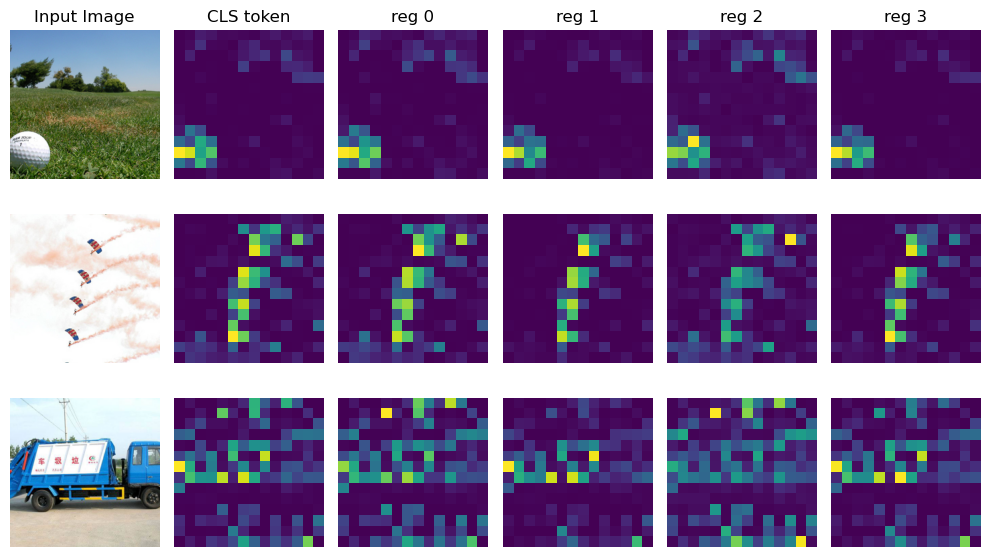

In [6]:
# Load model
pths = os.listdir('reg_checkpoints')
pths.remove("log.txt")
pths.sort()

checkpoint =torch.load(f'reg_checkpoints/checkpoint.pth', map_location=torch.device('cpu'))
print('epoch', checkpoint['epoch'])

model = models_v2.vit_models(
    img_size = 224, patch_size=16, num_regs = 4, embed_dim=384, depth=12, num_heads=6, mlp_ratio=4, qkv_bias=True,
    norm_layer=partial(nn.LayerNorm, eps=1e-6),block_layers=models_v2.Layer_scale_init_Block)
model.default_cfg = models_v2._cfg()

model.load_state_dict(checkpoint["model"])

# Set up plot
output_format = ((model.num_regs + 1)*2, len(imgs)*2)
fig, ax = plt.subplots(len(imgs), model.num_regs+2, figsize=output_format)

for n_image, image in enumerate(chosen_imgs):

    # Display the original image
    x = to_tensor(image)
    img_resized = x.permute(1, 2, 0) * 0.5 + 0.5

    ax[n_image, 0].imshow(np.array(img_resized))
    ax[n_image, 0].axis('off')

    # Display the attention maps for each layer
    block = model.blocks[-1]
    block.attn.forward = my_forward_wrapper(block.attn)

    y = model(x.unsqueeze(0))
    cls_weight =  block.attn.cls_attn_map.mean(dim=1)[:, 4:].detach().view(14, 14)

    ax[n_image, 1].imshow(cls_weight)
    ax[n_image, 1].axis('off')

    reg_weights = block.attn.reg_attn_maps[0].mean(dim=0)

    for n, reg_token in enumerate(reg_weights):
        reg_weight =reg_weights[n, 4:].detach().view(14, 14)
        ax[n_image, n+2].imshow(reg_weight)
        ax[n_image, n+2].axis('off')



# Set titles only to first row
ax[0, 0].set_title('Input Image')
ax[0, 1].set_title('CLS token')
for i in range(model.num_regs):
    ax[0, i+2].set_title(f'reg {i}')

plt.tight_layout()
plt.show()